<a href="https://colab.research.google.com/github/NosenkoArtem/MADMO-advanced-/blob/master/week_4/%5Bseminar%5Dclsf_transformer_solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

from random import random

Обратитесь к лекции, чтобы осознать, что такое self-attention.

In [ ]:
class SelfAttentionBlock(nn.Module):
    def __init__(self, emb, heads=8):
        """
        :param emb:
        :param heads:
        """

        super().__init__()

        self.emb = emb
        self.heads = heads

        self.tokeys = nn.Linear(emb, emb*heads, bias=False)
        self.toqueries = nn.Linear(emb, emb*heads, bias=False) 
        self.tovalues = nn.Linear(emb, emb*heads, bias=False)

        self.unifyheads = nn.Linear(heads*emb, emb)

    def forward(self, x):

        b, t, e = x.size()
        h = self.heads
        assert e == self.emb, f'Input embedding dim ({e}) \
        should match layer embedding dim ({self.emb})'

        keys    = self.tokeys(x).view(b, t, h, e)
        queries = self.toqueries(x).view(b, t, h, e)
        values  = self.tovalues(x).view(b, t, h, e)

        # compute scaled dot-product self-attention
        # 
        # - fold heads into the batch dimension
        keys = keys.transpose(1, 2).contiguous().view(b*h, t, e)
        queries = queries.transpose(1, 2).contiguous().view(b*h, t, e)
        values = values.transpose(1, 2).contiguous().view(b*h, t, e)

        queries = queries / (e ** (1/4))
        keys    = keys / (e ** (1/4))
        # - Instead of dividing the dot products by sqrt(e), we scale the keys and values.
        #   This should be more memory efficient

        # - get dot product of queries and keys, and scale
        dot = torch.bmm(queries, keys.transpose(1, 2)) # b*h x t x t

        assert dot.size() == (b*h, t, t)

        dot = F.softmax(dot, dim=2)
        # - dot now has row-wise self-attention probabilities

        # apply the self attention to the values
        #Next, we need to compute the dot products. 
        #This is the same operation for every head, so we fold the heads into the batch dimension. 
        out = torch.bmm(dot, values).view(b, h, t, e)

        # swap h, t back, unify heads
        out = out.transpose(1, 2).contiguous().view(b, t, h *e)

        return self.unifyheads(out) # h*e -> e

В данной ячейке необходимо написать код для блока трансформера, который работает непосредственно с 

Другими словами, блок применяется последовательно: слой self-attention, слой Layer Normalization, слой FF (один MLP применяется независимо к каждому вектору) и снова нормализация. Skip connections добавляются вокруг обоих блоков, перед нормализацией.
 Порядок различных компонентов не высечен на камне; важно сочетать self-attention с FFN, а также добавлять нормализацию и skips. Но делать это можно как и в сендвиче в любом порядке ( конечно же этот момент люди уже изучили).


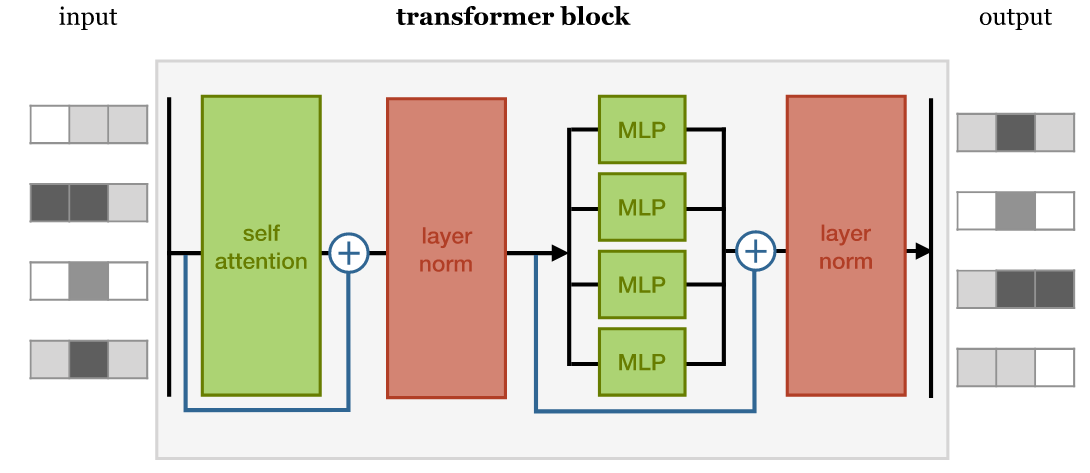

In [ ]:
class TransformerBlock(nn.Module):

    def __init__(self, emb, heads, seq_length, ff_hidden_mult=4, dropout=0.0):
        super().__init__()

        self.attention = SelfAttentionBlock(emb, heads=heads)

        self.norm1 = nn.LayerNorm(emb)
        self.norm2 = nn.LayerNorm(emb)

        self.ff = nn.Sequential(
           nn.Linear(emb, ff_hidden_mult*emb),
           nn.LeakyReLU(),
           nn.Linear(ff_hidden_mult*emb, emb)
        )

        self.do = nn.Dropout(dropout)

    def forward(self, x):

        attended = self.attention(x)

        x = self.norm1(attended + x)

        x = self.do(x)

        fforward = self.ff(x)
        #
        x = self.norm2(fforward + x)

        x = self.do(x)

        return x

В классе ниже необходимо заполнить информацию о вашем трансформере, который будет использоваться для классификации.
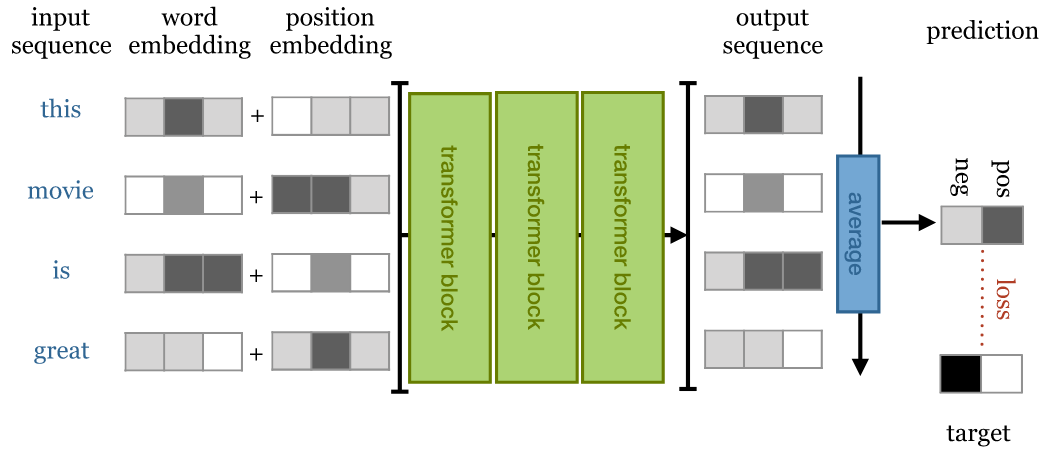

In [ ]:
class Classifier(nn.Module):
    """
    Transformer for classifying sequences
    """

    def __init__(self, emb, heads, depth, seq_length, num_tokens, num_classes,
                 max_pool=True, dropout=0.0, wide=False):
        """
        :param emb: Embedding dimension
        :param heads: number of attention heads
        :param depth: Number of transformer blocks
        :param seq_length: Expected maximum sequence length
        :param num_tokens: Number of tokens (usually words) in the vocabulary
        :param num_classes: Number of classes.
        :param max_pool: If true, use global max pooling in the last layer. If false, use global
                         average pooling.
        """
        super().__init__()

        self.num_tokens, self.max_pool = num_tokens, max_pool

        self.token_embedding = nn.Embedding(num_embeddings=num_tokens,
                                            embedding_dim=emb)
        self.pos_embedding = nn.Embedding(num_embeddings=seq_length,
                                            embedding_dim=emb)
        tblocks = []
        for i in range(depth):
            tblocks.append(
                TransformerBlock(emb=emb,
                                 heads=heads, 
                                 seq_length=seq_length, 
                                 dropout=dropout))

        self.tblocks = nn.Sequential(*tblocks)

        self.toprobs = nn.Linear(emb, num_classes)

        self.do = nn.Dropout(dropout)

    def forward(self, x):
        """
        :param x: A batch by sequence length integer tensor of token indices.
        :return: predicted log-probability vectors for each token based on the preceding tokens.
        """
        tokens = self.token_embedding(x)
        b, t, e = tokens.size()

        # Helper 
        positions = self.pos_embedding(torch.arange(t, device=x.device))[None, :, :].expand(b, t, e)
        x = tokens + positions
        x = self.do(x)

        x = self.tblocks(x) # apply transformers
        
        # pool over the time dimension
        x = x.max(dim=1)[0] if self.max_pool else x.mean(dim=1) 

        x = self.toprobs(x) # project 

        return F.log_softmax(x, dim=1)

In [ ]:
from tqdm import tqdm
from torchtext import data, datasets, vocab


TEXT = data.Field(lower=True, include_lengths=True, batch_first=True)
LABEL = data.Field(sequential=False)
NUM_CLS = 2
NUM_EPOCHS = 10

@torch.no_grad()
def validate_clsf(model, test_iter, mx,device=torch.device('cuda' if torch.cuda.is_available() else 'cpu') ):
    model.train(False)
    tot, cor= 0.0, 0.0

    for batch in test_iter:

        input_tt = batch.text[0]
        label = batch.label - 1

        if input_tt.size(1) > mx:
            input_tt = input_tt[:, :mx]
        out = model(input_tt.to(device)).argmax(dim=1)

        tot += float(input_tt.size(0))
        cor += float((label == out).sum().item())

    acc = cor / tot
    return acc

def train_classifier(device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    """
    Creates and trains a basic transformer for the IMDB sentiment classification task.
    """

    max_length = 512
    embedding_size = 128
    num_heads = 8
    depth = 6
    vocab_size = 30000
    max_pool = True
    lr = 0.0001
    lr_warmup = 10000
    batch_size = 4

    # load the IMDB data
    tdata, _ = datasets.IMDB.splits(TEXT, LABEL)
    train, test = tdata.split(split_ratio=0.8)

    TEXT.build_vocab(train, max_size=vocab_size - 2) # - 2 to make space for <unk> and <pad>
    LABEL.build_vocab(train)

    train_iter, test_iter = data.BucketIterator.splits((train, test), batch_size=batch_size, device=device)

    print(f'- nr. of training examples {len(train_iter)}')
    print(f'Number of examples in test {len(test_iter)}')

    if max_length < 0:
        mx = max([input.text[0].size(1) for input in train_iter])
        mx = mx * 2
        print(f'- maximum sequence length: {mx}')
    else:
        mx = max_length

    # create the model
    model = Classifier(emb=embedding_size, heads=num_heads, depth=depth,
                       seq_length=mx, num_tokens=vocab_size,
                       num_classes=NUM_CLS, max_pool=max_pool)
    if torch.cuda.is_available():
        model.cuda()

    opt = torch.optim.Adam(lr=lr, params=model.parameters())
    sch = torch.optim.lr_scheduler.LambdaLR(opt, 
                                            lambda i: min(i / (lr_warmup / batch_size), 1.0))

    # training loop
    seen = 0

    acc = validate_clsf(model, test_iter, mx)
    print(f'\n test accuracy {acc:.3}')

    for e in range(NUM_EPOCHS):

        print(f'\n epoch {e}')
        model.train(True)

        for batch in tqdm(train_iter):

            opt.zero_grad()

            input = batch.text[0]
            label = batch.label - 1

            if input.size(1) > mx:
                input = input[:, :mx]
            out = model(input.to(device))
            loss = F.nll_loss(out, label)

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 2.5)
            # clip gradients
            opt.step()
            sch.step()

            seen += input.size(0)

        # with torch.no_grad():
        acc = validate_clsf(model, test_iter, mx)
        print(f'\n test accuracy {acc:.3}')
    return model

In [ ]:
model = train_classifier()

- nr. of training examples 5000
Number of examples in test 1250


  0%|          | 0/5000 [00:00<?, ?it/s]


 test accuracy 0.495

 epoch 0


 24%|██▎       | 1178/5000 [02:01<05:48, 10.97it/s]

Вот так просто можно было завести на всем известном датасете своего трансформера.
